# Exercise 5 - Variational quantum eigensolver

### References

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 1-7.
2. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.
3. Sokolov, Igor O., et al. "Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers." Physical Review Research 3.1 (2021): 013125.


# The Task: Go through the part 1. In Part 2 try different approaches to get the best result.

## Part 1: Tutorial - VQE for H$_2$ molecule 



In this part, you will simulate H$_2$ molecule using the STO-3G basis with the PySCF driver and Jordan-Wigner mapping.


#### 1. Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers.
We have for example `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver` are available. 

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [6]:
from qiskit_nature.drivers import PySCFDriver

molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

<div class="alert alert-block alert-success">

<b> Try this</b>

If you look into the attributes of `qmolecule`, you are able to know the main information about it.

1. The total number of electrons in the system

`n_el = qmolecule.num_alpha + qmolecule.num_beta`
    
2. The number of molecular orbitals

`n_mo = qmolecule.num_molecular_orbitals`
    
3. Number of spin-orbitals

`n_so = 2 * qmolecule.num_molecular_orbitals`
    
4. How many qubits would you need to simulate this molecule with Jordan-Wigner mapping?

`n_q = 2* qmolecule.num_molecular_orbitals`
    
5. What is the value of the nuclear repulsion energy?

`e_nn = qmolecule.nuclear_repulsion_energy`
    
    
</div>

In [7]:
# like this
print('num molecular orbitals = ', qmolecule.num_molecular_orbitals)
print('nuclear repulsion energy = ', qmolecule.nuclear_repulsion_energy)

num molecular orbitals =  2
nuclear repulsion energy =  0.7160720039512857


#### 2. Electronic structure problem

You can then create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings).

In [8]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

#### 3. QubitConverter

Allows to define the mapping that you will use in the simulation. You can try different mapping but 
we will stick to `JordanWignerMapper` as allows a simple correspondence: a qubit represents a spin-orbital in the molecule.

In [9]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

#### 4. Initial state
As we described in the Theory section, a good initial state in chemistry is the HF state (i.e. $|\Psi_{HF} \rangle = |0101 \rangle$). We can initialize it as follows:

In [10]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


#### 5. Ansatz
One of the most important choices is the quantum circuit that you choose to approximate your ground state.
Here is the example of qiskit circuit library that contains many possibilities for making your own circuit.

In [11]:
from qiskit.circuit.library import TwoLocal, EfficientSU2 
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)

print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐                    ┌──────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■────■─────────■──┤ RY(θ[8]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘┌─┴─┐  │         │  └──────────┘»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[5]) ├────────────┤ X ├──┼────■────┼───────■──────»
     └──┬───┬───┘├──────────┤┌──────────┐└───┘┌─┴─┐┌─┴─┐  │       │      »
q_2: ───┤ X ├────┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼──────»
     ┌──┴───┴───┐├──────────┤└──────────┘     └───┘└───┘┌─┴─┐   ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├───────────────────────────┤ X ├───┤ X ├────»
     └──────────┘└──────────┘                           └───┘   └───┘    »
«     ┌───────────┐                                         ┌───────────┐»
«q_0: ┤ RZ(θ[12]) ├───────────────────■────────■─────────■──┤ RY(θ[16]) ├»
«     └┬──────────┤┌───────────┐    ┌─┴─┐      │         │  └───────────┘»
«q_1: ─┤ RY(θ[9]) ├┤ RZ(θ[13]) ├────┤ X ├──────┼────■────┼────────■──────»
«      └──────────┘├─────

#### 6. Backend
This is where you specify the simulator or device where you want to run your algorithm.
We will focus on the `statevector_simulator` in this challenge.


In [12]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.
A clever choice might reduce drastically the number of needed energy evaluations.

In [13]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

#### 8. Exact eigensolver
For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE.
Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so you can try doing this for a large molecule of your choice and see how slow this becomes. 
For very large systems you would run out of memory trying to store their wavefunctions.

In [14]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.8533636186720364
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.853363618672
  - computed part:      -1.853363618672
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.137291614721
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [15]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 500,
    'eigenstate': array([ 5.55839219e-07+4.33667242e-05j, -2.54817228e-04+1.69136374e-04j,
       -1.41198727e-05+1.07852951e-05j, -2.98933473e-05+3.34001403e-05j,
       -9.30756867e-06-2.69271113e-06j,  9.59165537e-01+2.59526293e-01j,
        4.01826666e-04-2.39628624e-04j, -6.72818471e-08+1.34512394e-07j,
        3.66141410e-08-2.52535990e-08j, -7.66350067e-04+4.00786325e-04j,
       -1.08531209e-01-2.94523377e-02j,  8.41316477e-05-1.50598909e-05j,
        3.82451399e-06-3.01452469e-06j,  1.24046236e-04-9.64048191e-05j,
       -3.11599148e-05-1.51052025e-05j, -1.17678002e-04+1.17115410e-05j]),
    'eigenvalue': -1.8533628495566552,
    'optimal_parameters': {   ParameterVectorElement(θ[16]): -0.00043981623804380666,
                              ParameterVectorElement(θ[17]): 3.1416457403459686,
                              ParameterVectorElement(θ[10]): -0.0003977930893254482,
                              Param

#### 9. Scoring function 
We need to judge how good are your VQE simulations, your choice of ansatz/optimizer.
For this, we implemented the following simple scoring function:

$$ score = N_{CNOT}$$

where $N_{CNOT}$ is the number of CNOTs. 
But you have to reach the chemical accuracy which is $\delta E_{chem} = 0.004$ Ha $= 4$ mHa, which may be hard to reach depending on the problem. 
You have to reach the accuracy we set in a minimal number of CNOTs to win the challenge. 
The lower the score the better!

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"[ry, rz]",cx,full,3,0.000769,True,18


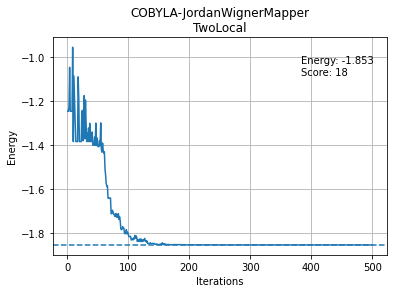

In [16]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value
accuracy_thresholdaccuract_thres = 4.0

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_thresholdaccuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

## Part 2: VQE for LiH molecule 


In this part, you will simulate LiH molecule using the STO-3G basis with the PySCF driver.

<div class="alert alert-block alert-danger">
    
<b>The task</b> 

Experiment with all the parameters (mapper, ansatz_type and optimizer) and try to make the error and the score (look at the table) as small as possible.
In ansatz you can also change the type of entanglement    
</div>



In [25]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit_nature.transformers import FreezeCoreTransformer, ActiveSpaceTransformer

In [26]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [27]:
problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
# setup the initial state for the ansatz

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

print('num_spin_orbitals', num_spin_orbitals)
print('num_particles', num_particles)

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

num_spin_orbitals 12
num_particles (2, 2)


In [28]:
print(init_state)

      ┌───┐
 q_0: ┤ X ├
      ├───┤
 q_1: ┤ X ├
      └───┘
 q_2: ─────
           
 q_3: ─────
           
 q_4: ─────
           
 q_5: ─────
      ┌───┐
 q_6: ┤ X ├
      ├───┤
 q_7: ┤ X ├
      └───┘
 q_8: ─────
           
 q_9: ─────
           
q_10: ─────
           
q_11: ─────
           


In [30]:
# setup the ansatz for VQE

#Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry', 'rz']
# Entangling gates
entanglement_blocks = 'cx'
# How the qubits are entangled 
entanglement = 'full'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 3
# Skip the final rotation_blocks layer
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)

# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)

# set the backend for the quantum computation
backend = Aer.get_backend('statevector_simulator')

# setup the classical optimizer for VQE
optimizer = L_BFGS_B(maxiter=500)

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1067,
    'eigenstate': array([-2.53421681e-07+4.59188653e-08j,  2.72182696e-05-4.57938507e-06j,
        3.27878437e-07-5.74918814e-08j, ...,
        5.41696874e-07-6.80221665e-08j, -5.74441885e-09-1.41789492e-09j,
        1.42820323e-06+3.09139760e-08j]),
    'eigenvalue': -8.223378317148816,
    'optimal_parameters': {   ParameterVectorElement(θ[20]): 0.010142546991172985,
                              ParameterVectorElement(θ[65]): 0.010056695109088501,
                              ParameterVectorElement(θ[66]): 0.00866764929223768,
                              ParameterVectorElement(θ[67]): 0.00959271369767693,
                              ParameterVectorElement(θ[68]): 0.009989468860160049,
                              ParameterVectorElement(θ[69]): 0.010011822861066012,
                              ParameterVectorElement(θ[70]): 0.010066480074548682,
                              ParameterVectorElement(θ[71]): 

In [31]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -8.90869711642424
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697116424
  - computed part:      -8.908697116424
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882762236781
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.74455828]
    - computed part:      [0.0  0.0  4.74455828]
  > Dipole moment (a.u.): [0.0  0.0  -1.82039607]  Total: 1.82039607
                 (debye): [0.0  0.0  -4.62698485]  Total: 4.62698485
 


,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000769,True,18
0,L_BFGS_B,TwoLocal,12,96,"[ry, rz]",cx,full,3,685.318799,False,198


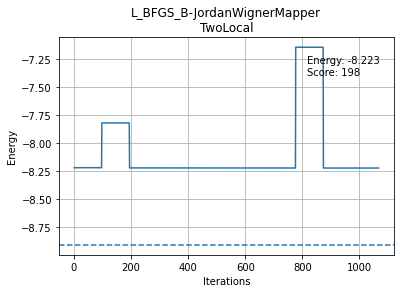

In [32]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

ansatz_type = 'TwoLocal'

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value
accuracy_thresholdaccuract_thres = 4.0

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_thresholdaccuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
#fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]